In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np

# Question 1

Simulate a time series with $n = 500$ realisations distributed according to a probability law $L$ of your choice. This time series must have $K^∗ ≥ 2$ changes in one or more dimensions of the parameters of $L$ (you set the value of $K^∗$ as you wish). Plot this time series.

In [2]:
def expovariate(l):
    return lambda : random.expovariate(l)

In [3]:
exp_1 = expovariate(1)
exp_4 = expovariate(4)
exp_5 = expovariate(5)

In [4]:
def generate_time_series(interval : tuple[int,int],
                         change_points: list[int],
                         distributions):
    '''
    `interval`: 
    `change_points`: 
    `distributions`:
    '''
    time_series = []
    points =  [interval[0]] + change_points + [interval[1]]
    for p in range(len(distributions)):
        point_left = points[p]
        point_right = points[p + 1]
        for _ in range(point_left, point_right, 1):
            time_series.append(distributions[p]())
    return time_series


In [5]:
def plot_time_series(time_series, change_points= None, approx_change_points= None):
    plt.plot(range(len(time_series)), time_series, '.', color= 'black')
    min_point = min(time_series)
    max_point = max(time_series)
    if change_points is not None:
        for change_point in change_points:
            plt.vlines(change_point, min_point, max_point, colors= 'gray', linestyles='dashed')
    if approx_change_points is not None:
        for change_point in approx_change_points:
            plt.vlines(change_point, min_point, max_point, colors= 'red', linestyles='dashed')
    plt.show()

In [6]:
interval = (0, 400)
change_points = [200, 250, 300]
distributions = [exp_1, exp_5, exp_1, exp_4]
time_series = generate_time_series(interval, change_points, distributions)

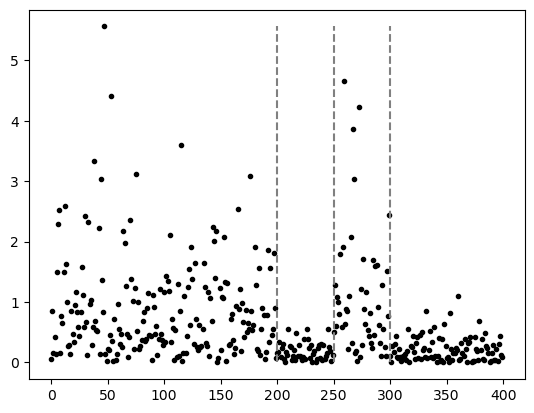

In [7]:
plot_time_series(time_series, change_points)

# Question 2

Derive a cost function that is appropriate for the data simulated in Question 1. Briefly justify your choice (in a comment in your code).

In [19]:
def cost_funtion_exp(points):
    n = len(points)
    try:
        return len(points) * (1 - math.log(n / sum(points)))
    except:
        print(points, sum(points))
        return 0

# Question 3

Implement the optimal partition algorithm and test it on the data simulated in question 1.

In [9]:
def OptimalPartition(points, cost_func, K):

    n = len(points)
    Ms = np.zeros((K,n,n))
    for u in range(n):
        for v in range(n):
            if u < v:
                Ms[0][u][v] = cost_func(points[u:v+1])

    if K + 1 > 2:
        for k in range(1, K):
            for u in range(n):
                for v in range(n):
                    if v-u > k+1:
                        Ms[k][u][v] = min([Ms[k-1][u][t] + Ms[0][t+1][v] for t in range(u+k-1, v)])
    L = np.zeros((K+1), dtype=int)
    L[K] = n-1
    k = K
    while k > 0:
        s = L[k]        
        ts = [Ms[k-1][0][t] + Ms[0][t+1][s] for t in range(k, s)]
        ts_min =  min(ts)
        t_index = ts.index(ts_min)
        L[k-1] = t_index
        k= k -1
    return L
    

In [10]:
approx_change_points = OptimalPartition(time_series, cost_funtion_exp, 3)
approx_change_points

array([197, 247, 296, 399])

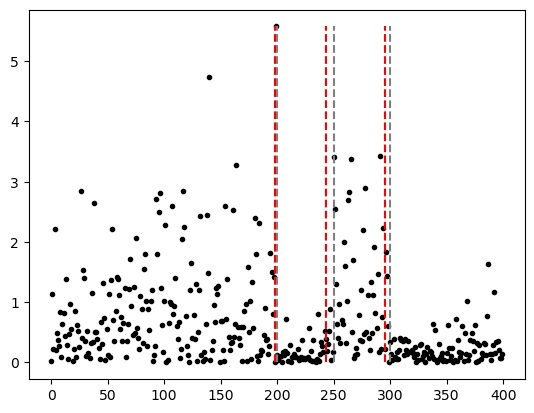

In [15]:
plot_time_series(time_series, change_points, approx_change_points[:-1])

# Question 4

Implement the PELT algorithm and test it using the data simulated in question 1. You will set the value of the penalty weight as $log(n)$.

In [247]:
def PELT(points, cost_func, penalty= None, n_min=2, K= 0):

    n = len(points)
    F = np.zeros(n, np.float32)

    if penalty is None:
        penalty = np.log(n)

    for i in range(n_min):
        F[i] = - penalty
    CP = np.zeros(n, np.int32)
    R = np.array([0], dtype=np.int32)

    for t_accent in range(n_min, n):
        
        np.array(F[t_accent])         
        interval_costs = np.zeros(R.shape[0], np.float32)
        for i, change_point_cand in enumerate(R):            
            interval_costs[i] = F[change_point_cand] + cost_func(points[change_point_cand: t_accent])

        F[t_accent] = min(interval_costs + penalty)
        CP[t_accent] = R[np.argmin(interval_costs + penalty)]
        
        R_new = []
        for i, val in enumerate(interval_costs):
            if val + K < F[t_accent]:
                R_new.append(R[i])
        R_new.append(t_accent)
        R = np.array(R_new, dtype=np.int32)

    finals_CP = []
    last = CP[-1]
    while last > 0:
        finals_CP.append(last)
        last = CP[last]
    finals_CP.reverse()
    return finals_CP

In [249]:
approx_change_points_PELT = PELT(time_series, cost_funtion_exp,n_min=5)
approx_change_points_PELT

[199, 250, 300]

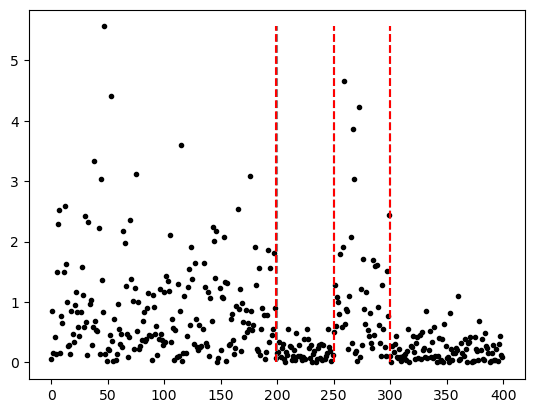

In [251]:
plot_time_series(time_series, change_points, approx_change_points_PELT)

# Question 5

Test the PELT algorithm with other values of the penalty weight. Comment the results.